<a href="https://colab.research.google.com/github/jblanco89/ML-Zoomcamp-course/blob/main/ML_Zoomcamp_homework_w3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification
## ML Zoomcamp

### Homework Module 3

*Author:* Javier Blanco


In [103]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

## Dataset

In [26]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-02 15:05:58--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.6’

data.csv.6          100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2023-10-02 15:05:58 (39.0 MB/s) - ‘data.csv.6’ saved [1475504/1475504]



## Data Preparation

target: `MSRP`

Features:
* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`

In [27]:
car_price_raw = pd.read_csv('data.csv', sep=',')
car_price_df = car_price_raw[['Make','Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]
car_price_df.columns = car_price_df.columns.str.replace(' ', '_').str.lower()
car_price_df = car_price_df.rename(columns={'msrp':'price'})
car_price_df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [28]:
car_price_df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [29]:
car_price_df['engine_hp'] = car_price_df['engine_hp'].fillna(car_price_df['engine_hp'].mean())

In [30]:
car_price_df.isna().sum()

make                  0
model                 0
year                  0
engine_hp             0
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [31]:
car_price_df = car_price_df.dropna(axis=0)

In [32]:
car_price_df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

### Question 1

What is the most frequent observation (mode) for the column `transmission_type`?

- `AUTOMATIC`
- `MANUAL`
- `AUTOMATED_MANUAL`
- `DIRECT_DRIVE`


<Axes: >

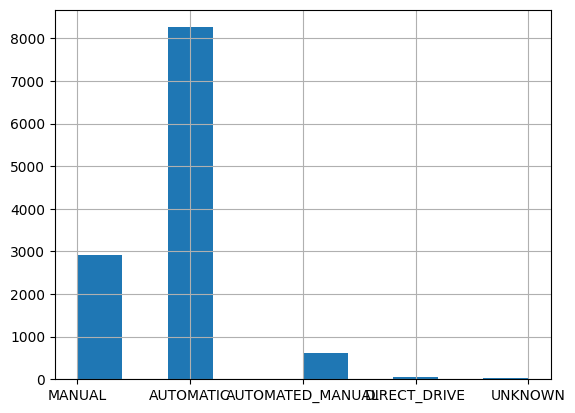

In [33]:
car_price_df['transmission_type'].hist()

R. `AUTOMATIC`

### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset.
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

- `engine_hp` and `year`
- `engine_hp` and `engine_cylinders`
- `highway_mpg` and `engine_cylinders`
- `highway_mpg` and `city_mpg`

In [34]:
car_price_df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
dtype: object

In [35]:
car_price_df.columns = car_price_df.columns.str.lower().str.replace(' ', '_')

string_columns = list(car_price_df.dtypes[car_price_df.dtypes == 'object'].index)

for col in string_columns:
    car_price_df[col] = car_price_df[col].str.lower().str.replace(' ', '_')

In [36]:
car_price_df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
dtype: object

In [37]:
numerical = car_price_df[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']]
numerical.corr().style.background_gradient(cmap='coolwarm')

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,1.000000,0.352377,-0.041479,0.261362,0.202815
engine_hp,0.352377,1.000000,0.765437,-0.357669,-0.357163
engine_cylinders,-0.041479,0.765437,1.000000,-0.621606,-0.600776
highway_mpg,0.261362,-0.357669,-0.621606,1.000000,0.880508
city_mpg,0.202815,-0.357163,-0.600776,0.880508,1.000000


R. `highway_mpg` and `city_mpg`

In [38]:
categorical = car_price_df[['make', 'model', 'transmission_type', 'vehicle_style']]

## Data Wrangling
### Make `price` binary

* Now we need to turn the `price` variable from numeric into a binary format.
* Let's create a variable `above_average` which is `1` if the `price` is above its mean value and `0` otherwise.

### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value (`price`) is not in your dataframe.


In [39]:
car_price_mean = car_price_df['price'].mean()
car_price_df['above_average'] = [1 if car_price > car_price_mean else 0 for car_price in car_price_df['price']]

In [40]:
car_price_df[['price', 'above_average']].head()

,price,above_average
0,46135,1
1,40650,1
2,36350,0
3,29450,0
4,34500,0


<Axes: >

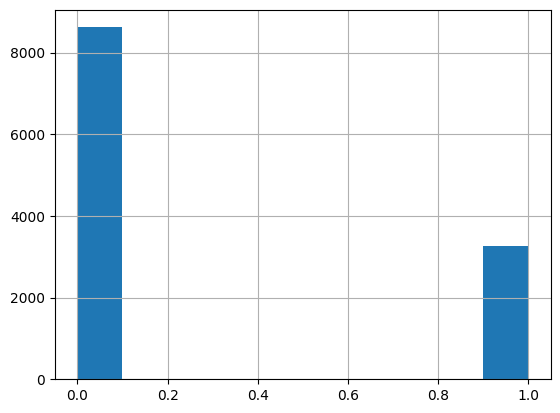

In [41]:
## Imbalanced data here
car_price_df['above_average'].hist()

Splitting data

In [42]:
X = car_price_df.drop(columns=['price', 'above_average'])
y = car_price_df['above_average']

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2,
                                                 random_state=42,
                                                 shuffle=True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.25,
                                                 random_state=42,
                                                 shuffle=True)

In [45]:
X_train.shape

(7130, 9)

In [46]:
X_val.shape

(2377, 9)

In [47]:
X_test.shape

(2377, 9)

### Question 3

* Calculate the mutual information score between `above_average` and other categorical variables in our dataset.
  Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the lowest mutual information score?
  
- `make`
- `model`
- `transmission_type`
- `vehicle_style`


One-hot encoding

In [48]:
categorical = X_train[categorical.columns]
cat_columns = list(categorical.columns)
cat_columns

['make', 'model', 'transmission_type', 'vehicle_style']

In [49]:
categorical

,make,model,transmission_type,vehicle_style
6221,nissan,juke,automatic,4dr_hatchback
9229,toyota,sienna,automatic,passenger_minivan
5393,volkswagen,golf_gti,manual,4dr_hatchback
4271,infiniti,ex35,automatic,4dr_suv
5218,lamborghini,gallardo,manual,coupe
...,...,...,...,...
9102,nissan,sentra,manual,sedan
7494,honda,passport,manual,4dr_suv
10412,volkswagen,tiguan,automatic,4dr_suv
3534,aston_martin,db9,automatic,convertible


In [50]:
cat_target = pd.concat([categorical, y_train], axis=1)
cat_target

,make,model,transmission_type,vehicle_style,above_average
6221,nissan,juke,automatic,4dr_hatchback,0
9229,toyota,sienna,automatic,passenger_minivan,1
5393,volkswagen,golf_gti,manual,4dr_hatchback,0
4271,infiniti,ex35,automatic,4dr_suv,0
5218,lamborghini,gallardo,manual,coupe,1
...,...,...,...,...,...
9102,nissan,sentra,manual,sedan,0
7494,honda,passport,manual,4dr_suv,0
10412,volkswagen,tiguan,automatic,4dr_suv,0
3534,aston_martin,db9,automatic,convertible,1


In [51]:
def calculate_mi(series):
  return mutual_info_score(series, cat_target.above_average)

In [52]:
df_mi = X_train[categorical.columns].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
model,0.465639
make,0.240400
vehicle_style,0.082213
transmission_type,0.019432


R. `transmission_type`

### Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.60
- 0.72
- 0.84
- 0.95

In [53]:
from sklearn.feature_extraction import DictVectorizer

In [54]:
categorical.nunique()

make                  48
model                880
transmission_type      5
vehicle_style         16
dtype: int64

In [55]:
from pandas.core.arrays import numeric
train_dict = X_train.to_dict(orient='records')
train_dict[0]

{'make': 'nissan',
 'model': 'juke',
 'year': 2015,
 'engine_hp': 188.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'automatic',
 'vehicle_style': '4dr_hatchback',
 'highway_mpg': 32,
 'city_mpg': 28}

In [56]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [57]:
X_train = dv.transform(train_dict)
X_train

array([[  28.,    4.,  188., ...,    0.,    0., 2015.],
       [  16.,    6.,  266., ...,    0.,    0., 2016.],
       [  25.,    4.,  210., ...,    0.,    0., 2016.],
       ...,
       [  21.,    4.,  200., ...,    0.,    0., 2015.],
       [  13.,   12.,  510., ...,    0.,    0., 2015.],
       [  22.,    4.,  120., ...,    0.,    0., 1996.]])

In [58]:
X_train.shape

(7130, 954)

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
model = LogisticRegression(solver='liblinear',
                           C=10,
                           random_state=42,
                           max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [61]:
val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [62]:
model.predict_proba(X_val)

array([[9.97628164e-01, 2.37183602e-03],
       [9.99381431e-01, 6.18568870e-04],
       [9.99932039e-01, 6.79612044e-05],
       ...,
       [5.99587668e-01, 4.00412332e-01],
       [9.97839529e-01, 2.16047085e-03],
       [9.96023825e-01, 3.97617526e-03]])

In [63]:
y_pred_val = model.predict(X_val)

In [64]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0])

In [65]:
round(accuracy_score(y_val, y_pred_val),2)

0.94

R. `0.95`

### Question 5

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

- `year`
- `engine_hp`
- `transmission_type`
- `city_mpg`

> **Note**: the difference doesn't have to be positive

In [66]:
feature_list = ['year', 'engine_hp', 'transmission_type', 'city_mpg']
real_acc = 0.95
for i in feature_list:
  X_train_df = pd.DataFrame(train_dict)
  X = X_train_df.drop(columns=i)
  X_dict = X.to_dict(orient='records')
  dv.fit(X_dict)
  X = dv.transform(X_dict)
  model = LogisticRegression(solver='liblinear',
                           C=10,
                           random_state=42,
                           max_iter=1000)
  model.fit(X, y_train)

  y_pred = model.predict(X)
  new_acc = accuracy_score(y_train, y_pred)
  diff = np.abs(real_acc - new_acc)
  print(i, diff, diff*100)




year 0.008345021037868161 0.8345021037868161
engine_hp 0.007924263674614296 0.7924263674614296
transmission_type 0.0056802244039271255 0.5680224403927125
city_mpg 0.005119214586255305 0.5119214586255305


R. `city_mpg`

### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn.
* We'll need to use the original column `price`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data with a solver `'sag'`. Set the seed to `42`.
* This model also has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`.
* Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

- 0
- 0.01
- 0.1
- 1
- 10

> **Note**: If there are multiple options, select the smallest `alpha`.


In [104]:
np.random.seed(42)
model_ridge = Ridge(alpha=0, solver='sag')

In [97]:
target = np.log(car_price_df['price'])
target

0        10.739327
1        10.612754
2        10.500949
3        10.290449
4        10.448715
           ...    
11909    10.739002
11910    10.945000
11911    10.832102
11912    10.838011
11913    10.274879
Name: price, Length: 11884, dtype: float64

In [100]:
features = car_price_df.drop(columns=['price', 'above_average', 'make', 'model', 'transmission_type', 'vehicle_style'])
features

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
0,2011,335.0,6.0,26,19
1,2011,300.0,6.0,28,19
2,2011,300.0,6.0,28,20
3,2011,230.0,6.0,28,18
4,2011,230.0,6.0,28,18
...,...,...,...,...,...
11909,2012,300.0,6.0,23,16
11910,2012,300.0,6.0,23,16
11911,2012,300.0,6.0,23,16
11912,2013,300.0,6.0,23,16


In [101]:
X_train, X_val, y_train, y_val = train_test_split(features, target,test_size=0.2,
                                                 random_state=42,
                                                 shuffle=True)

In [107]:
ridge = model_ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)
rmse = mean_squared_error(y_val, y_pred_val)
rmse


97.87657297977837

In [109]:
# np.random.seed(42)
alphas = [0, 0.01, 0.1, 1, 10]
for alpha in alphas:
  model_ridge = Ridge(alpha=alpha, solver='sag')
  ridge = model_ridge.fit(X_train, y_train)
  y_pred_ridge = ridge.predict(X_val)
  rmse = mean_squared_error(y_val, y_pred_val)
  print(f'alpha:{alpha}, rmse: {rmse}')

alpha:0, rmse: 97.87657297977837
alpha:0.01, rmse: 97.87657297977837
alpha:0.1, rmse: 97.87657297977837
alpha:1, rmse: 97.87657297977837
alpha:10, rmse: 97.87657297977837


R. `0`